With the goal of building a mini-tolkien LLM from scratch I will start just with some basic ideas to understand how LLMs predict the next token.    

In [28]:
with open("the_lord_of_the_rings.txt", "r") as f:
    lotr = f.read()
print("Lord of the Rings content loaded. Char count =", len(lotr))

Lord of the Rings content loaded. Char count = 1021112


In [29]:
print(lotr[0:500])

Three Rings for the Elven-kings under the sky,
               Seven for the Dwarf-lords in their halls of stone,
            Nine for Mortal Men doomed to die,
              One for the Dark Lord on his dark throne
           In the Land of Mordor where the Shadows lie.
               One Ring to rule them all, One Ring to find them,
               One Ring to bring them all and in the darkness bind them
           In the Land of Mordor where the Shadows lie.
           
FOREWORD

This tale grew


In [30]:
chars = sorted(list(set(lotr))) # This is our vocab list. Just single characters for now.
"".join(chars) 

'\n !"\'(),-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ_`abcdefghijklmnopqrstuvwxyzÓáâäéëíóúû–'

This is the vocab list since I'm just going to start with next token generation based on one token prior. 

Real LLMs use 50000+ item vocab lists where the elements are words and parts of words. 

With that I will now add an encoder and decoder.

In [31]:
stoi =  { ch: i for i, ch in enumerate(chars)} # dict mapping string chars to int tokens.
itos =  { i: ch for i, ch in enumerate(chars)} # dict mapping tokens back to strings.

# with these mapping dicts we can write simple decode and encode functions.
encode = lambda s : [stoi[c] for c in s]
decode = lambda l : "".join([itos[i] for i in l])

In [32]:
print(encode("Hi there!"))
print(decode(encode("Hi there!")))

[32, 61, 1, 72, 60, 57, 70, 57, 2]
Hi there!


Great!

In [33]:
import torch
data = torch.tensor(encode(lotr), dtype=torch.long)
print(data.shape, data.dtype)
print()
print(lotr[0:50])
print(data[0:50])

torch.Size([1021112]) torch.int64

Three Rings for the Elven-kings under the sky,
   
tensor([44, 60, 70, 57, 57,  1, 42, 61, 66, 59, 71,  1, 58, 67, 70,  1, 72, 60,
        57,  1, 29, 64, 74, 57, 66,  8, 63, 61, 66, 59, 71,  1, 73, 66, 56, 57,
        70,  1, 72, 60, 57,  1, 71, 63, 77,  7,  0,  1,  1,  1])


Before doing any more let's do a little train-test split.

In [34]:
def train_test_split(data: list, split_size: int): 
    split_index = int(len(data)*split_size)
    return data[0:split_index], data[split_index:]

train_data, test_data = train_test_split(data, 0.9)
print("Train data length:", len(train_data))
print("Test data length:", len(test_data))

Train data length: 919000
Test data length: 102112


In [35]:
block_size = 8
train_data[:block_size+1]

tensor([44, 60, 70, 57, 57,  1, 42, 61, 66])

In [36]:
torch.manual_seed(3791) # Set manual seed for repeatability. There Rings for the Elven-kings... and so on.

batch_size = 4 # Number independant sequences of tokens we will process in parrallel
block_size = 8 # Maximum context length for predictions

def get_batch(data):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y, 

xb, yb = get_batch(train_data)

print("Inputs:")
print()
print(xb)
print("-----")
print("Targets:")
print()
print(yb)
print("-----")

for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target is: {target}")

Inputs:

tensor([[ 1, 68, 70, 67, 55, 57, 57, 56],
        [66, 56,  1, 72, 60, 61, 66, 63],
        [72, 60, 53, 72,  1, 60, 53, 56],
        [ 1, 72, 60, 57, 65,  1, 75, 60]])
-----
Targets:

tensor([[68, 70, 67, 55, 57, 57, 56, 71],
        [56,  1, 72, 60, 61, 66, 63, 61],
        [60, 53, 72,  1, 60, 53, 56,  1],
        [72, 60, 57, 65,  1, 75, 60, 57]])
-----
when input is [1] the target is: 68
when input is [1, 68] the target is: 70
when input is [1, 68, 70] the target is: 67
when input is [1, 68, 70, 67] the target is: 55
when input is [1, 68, 70, 67, 55] the target is: 57
when input is [1, 68, 70, 67, 55, 57] the target is: 57
when input is [1, 68, 70, 67, 55, 57, 57] the target is: 56
when input is [1, 68, 70, 67, 55, 57, 57, 56] the target is: 71
when input is [66] the target is: 56
when input is [66, 56] the target is: 1
when input is [66, 56, 1] the target is: 72
when input is [66, 56, 1, 72] the target is: 60
when input is [66, 56, 1, 72, 60] the target is: 61
when input

In [37]:
import torch.nn as nn
from torch.nn import functional as F

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size) -> None:
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    
    def forward(self, idx, targets=None):
        # Batch x Time x Channel, tensor prediction of what is next
        logits = self.token_embedding_table(idx) 

        if targets is None:
            loss = None
        else:
            # Based on the PyTorch docs we need a B*C x T tensor to calcualate loss
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits , loss 
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context.
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :] 
            probs = F.softmax(logits, dim=-1) 
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
    
m = BigramLanguageModel(len(chars)) 
m.generate(xb, 2)

tensor([[ 1, 68, 70, 67, 55, 57, 57, 56, 41,  4],
        [66, 56,  1, 72, 60, 61, 66, 63,  9,  9],
        [72, 60, 53, 72,  1, 60, 53, 56,  1, 54],
        [ 1, 72, 60, 57, 65,  1, 75, 60, 14, 86]])

In [38]:
idx_init = torch.zeros((1, 1), dtype=torch.long)
decode(m.generate(idx_init, max_new_tokens=100)[0].tolist())

"\n/9IFF;?Iú_M,KCnáJ9Cíkou cdwâ=O4GE4N 9-wlg7M;:3bjaëu`Y8Ná/)7fYy8\n,ëiWMKë=WëeD upjuUú/qSäc)FTk'4?Y–á3i"

This is a start but we can do better. 

We need three things to improve performance with the use of a training loop.

optimizer, loss, back prop

In [39]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

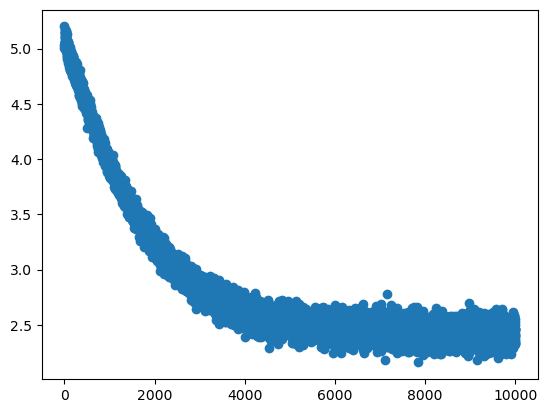

In [40]:
batch_size = 32
number_of_steps = 10000
losses = []

for steps in range(number_of_steps):
    xb, yb = get_batch(train_data)

    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

from matplotlib import pyplot as plt

plt.scatter(range(0, 10000), losses)

With this trained model we can just have a generate function for now.

In [41]:
def generate_text(model, text_length):
    idx_init = torch.zeros((1, 1), dtype=torch.long)
    return decode(model.generate(idx_init, max_new_tokens=text_length)[0].tolist())

print(generate_text(m, 1000))



 Nowongllopt mWend ooprsh f an  he if is s me `bon; y f lld in r tan,  atu we. she ADauthe ank Angarise foforsoon '
 w y ind   n  anxand a e dy f M, cav_ARily oy Galeindofr os cr.=/äpid rcad  iny sht, '
 oan.
 wit w rnd Se   'thalll  h).' tivewn t2_
 'Arolin the, btlorsidoune ng. wde
 g thelyey t A/eng w se sthet My Fome  wimood rlelbs ay,  s fe.ät iOf aret!ldis Thandsere Fou!ë' é'I anghe s wastunth RFOritheeresepremy: pe hinuent heme hép Th awea`Ridobowhiroot Brs t wngashayoumanut-m h senouPif wid frmin heigrd p  ArerKGaroondorCo fi03G; foruto spearen t owitenou ved an Oful Hing if pt oryoof rme wawinean le arlat. theng theark   ind  t. t mm.  n  isaine ?'
 uchut t  Galilin kEntoan afan irideausited ptrot`Brd agstheeshere  issat t t  e  ngaá/Ourowe so t xtit sarouthad?', tooway vee I is; blden'ok wagrd thevemit skeer ous ckery;_, rs. ds doutherad wind  he, to s oul sande, akiellyshedope se hesude imof f tr wed d whad anthp co ws, m,' akelifoprso jQDebu Br a  eetordofe  ade!
 nd de r

That's a bit closer. More elvish than english I think :)